## 요약

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 그래프의 폰트 출력을 선명하게 (svg, retina 등이 있음)
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("default")
# 이미지가 레이아웃 안으로 들어오도록 함
# https://matplotlib.org/stable/users/explain/axes/constrainedlayout_guide.html
mpl.rcParams.update({"figure.constrained_layout.use": True})

#font, line, marker 등의 배율 설정: paper, notebook, talk, poster
sns.set_context("paper") 
#배색 설정: tab10, Set2, Accent, husl
sns.set_palette("Set2") 
#눈금, 배경, 격자 설정: ticks, white, whitegrid, dark, darkgrid
# withegrid: 눈금을 그리고, 각 축의 눈금을 제거
sns.set_style("whitegrid") 

In [2]:
# 로컬에서 

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use('default')
mpl.rcParams.update({'figure.constrained_layout.use':True})

sns.set_context('paper')
sns.set_palette('Set2')
sns.set_style('whitegrid')

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [3]:
# 필요한 패키지 import
from bs4 import BeautifulSoup
import requests
import re
import os

In [4]:
PRJCT_PATH = '/Users/junsung/KDH_AI_DEV/project2/aladin/aladin_usedbook' # 개인파일경로

## 개요
- 국내 중고 도서 중 우주점 항목 페이지
  - https://www.aladin.co.kr/search/wsearchresult.aspx?SearchTarget=Used&KeyRecentPublish=0&OutStock=0&ViewType=Detail&SortOrder=11&CustReviewCount=0&CustReviewRank=0&KeyWord=&CategorySearch=55890%2C170%2C76001%2C2105%2C987%2C4395%2C8257%2C2551%2C798%2C1%2C1383%2C1108%2C55889%2C1196%2C74%2C517%2C1322%2C1230%2C13789%2C656%2C336%2C2913%2C1237%2C2030%2C76000%2C1137%2C50246%2C351%2C0%400&chkKeyTitle=&chkKeyAuthor=&chkKeyPublisher=&IsDirectDelivery=2&ViewRowCount=50&SuggestKeyWord=
- url 구조 :
  - 도서 판매 페이지
    - 예시: https://www.aladin.co.kr/shop/wproduct.aspx?ItemId=341311231
    - book id의 규칙은 잘 모르겠음
    - 책 제목에 \[중고\]가 있는 것으로 명확히 구분 가능
    - 품절도서/ 중고도서/ 일반도서의 페이지 구조가 다름
      - 품절도서 : 중고 모두보기가 있음
      - 중고도서 : 중고 모두보기가 있음, 새상품 상세보기 있음
      - 일반도서 : 위 두 사항 모두 해당 없음
  - 중고 정보 페이지
    - 예시 : https://www.aladin.co.kr/shop/UsedShop/wuseditemall.aspx?ItemId=329596&TabType=3&Fix=1
    - 새상품의 itemid / ``tabtype=3`` : 우주점 
    - 만약 itemid에 중고상품 아이디가 들어가면 중고상품의 중고상품 (즉 존재하지 않음)
    - 중고상품이 없는 item id가 들어가도 빈 페이지로 보임
- 어떻게 접근할 것인가?
    - 중고 접근 페이지 경유
    - 일반도서 itemid 수집 (방법 검색해보기) 이후 중고 정보 페이지 접근
    - 임의의 페이지 접근 후 페이지 유형에 따라 프로세스 진행
      - 새상품 상세보기가 없는 경우 : 중고 정보 페이지로 접근
      - 새상품 상세보기가 있는 경우 : 새상품 페이지의 링크에서 item id를 수집 후 중고 정보 페이지로 접근
      - 중고 정보 페이지에서 일괄 적으로 링크 수집
      - 이후 수집된 링크에 접근

- 중고 도서 판매 페이지 구조
  - 분류 : 알라딘 직접 배송/ 우주점 / 판매자 배송
    - selector : ```#Ere_prod_allwrap > div.Ere_prod_topwrap > div.Ere_prod_titlewrap > div.left > div > ul > li.Ere_label_wrap > span```
    - class가 bluebox, orangebox, greenbox
  - 필요한 정보
    - 도서 명, 저자, 출판사, 출판일시
      - 도서명 앞에 \[\]로 특수한 정보가 들어있을 수 있음을 주의
      - 도서 맨 뒤에 권 번호 등의 정보가 있을 수 있음을 주의
    - 정가, 정가대비 할인율
    - 중고 품질 등급
    - 새상품 관련 정보
      - 절판 도서는 SalesPoint가 없을 수 있음
        - 절판된 구판은 개정판 보기 링크 있음
        - 개정판에서도 구판으로 가는 링크 있음
      - 세트는 별도의 SalesPoint가 있음
      - isbn을 활용할 수 있음 


- DB를 두개 만드는 것도 좋을 듯
  - 새 상품 정보
    - 도서명, 저자, 출판사, 출판일시
    - 정가, 도서 분류, 세일즈 포인트, 절판 여부
  - 중고 상품 정보
    - 새 상품 id, 등급, 판매가
      - 정가보다 비쌀 경우 할인율이 안적혀 있을 수 있음 주의
      - 특히 판매자 중고의 경우 할인율이 일관적으로 적혀있지 않음
      - 할인율을 별도로 계산할 필요 있음 

**베스트 셀러 페이지**
- url 형식 : ``f'https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year={year}&Month={month}&Week={week}&page={page}&cnt=1000&SortOrder=1'``
    - year : 2000~2024
    - month : 1~12
    - week : 1~ 5
        - 2월도 week 5 존재
    - page : 1~20
    - 연도가 앞으로 갈수록 품절도서 확률 높아짐
    - 현재 2024.07 2nd week까지 있음
    - xls 파일 다운로드 가능
        - itemid 포함되어 있음
        - 저자, 상품명, 출판사, 정가, SalesPoint, 대표분류
        - 저자 정보 업데이트를 위한 경우를 제외하고는 xls의 정보 사용하면 될 듯
            - 동명이인 처리 등의 업데이트

**정해진 프로세스**

0. 임의의 연/월/주를 10개 골라서 itemid 목록 작성
1. 임의의 새 상품 페이지를 들어간다
2. 새 상품 관련 정보 수집
3. 해당 도서의 중고 정보 페이지로 접근
4. 각 도서별 중고 상품 정보 수집

In [5]:
size = 10
year_cand = range(2000,2025)
month_cand = range(1,13)
week_cand = range(1,6)
page_cand = range(1,21)

years = np.random.choice(year_cand,size)
months = np.random.choice(month_cand,size)
weeks = np.random.choice(week_cand,size)
#어차피 전체 페이지의 내용이 다운되기 때문에 페이지는 상관 없긴 함
pages= np.random.choice(page_cand,size)

url_format = 'https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year={}&Month={}&Week={}&page={}&cnt=1000&SortOrder=1'

for y,m,w,p in zip(years,months,weeks,pages):
    print(url_format.format(y,m,w,p))


https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2020&Month=12&Week=5&page=8&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2018&Month=1&Week=2&page=6&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2010&Month=6&Week=4&page=1&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2020&Month=1&Week=1&page=18&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2009&Month=6&Week=1&page=18&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2019&Month=11&Week=1&page=1&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2019&Month=4&Week=2&page=2&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.aspx?

위 url 링크에 들어가면 도서목록의 우측 상단에 xls로 다운 받는 링크 있음

xls 파일 다운 받은 뒤, csv 파일로 변경하여 사용

------

csv파일 주차별로 다운받는 코드

In [7]:
import requests

year = range(2005,2005)
month = range(1,13)
week = range(1,6)
# Define the URL to download the CSV file
url_format = 'http://www.aladin.co.kr/shop/common/wbest_excel.aspx?BestType=Bestseller&BranchType=1&CID=0&Year={}&Month={}&Week={}'
for y in year:
     for m in month:
          for w in week:
               print(url_format.format(y,m,w))
               url = url_format.format(y,m,w)
               response = requests.get(url)
               if response.status_code == 200:
                    file_path = '../samples/{}년{}월{}주_20240710.csv'                            
                    with open(file_path.format(y,m,w), 'wb') as file:
                        file.write(response.content)
                    print(f'File downloaded successfully and saved as {file_path}')
               else:
                    print(f'Failed to download the file. Status code: {response.status_code}')
               

http://www.aladin.co.kr/shop/common/wbest_excel.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2024&Month=7&Week=1
File downloaded successfully and saved as ../csv/{}년{}월{}주_20240710.csv
http://www.aladin.co.kr/shop/common/wbest_excel.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2024&Month=7&Week=2
File downloaded successfully and saved as ../csv/{}년{}월{}주_20240710.csv


In [7]:
dir_path = os.path.join(PRJCT_PATH,'samples')
files = os.listdir(dir_path)

df_dict = dict()

for file in files:
    if file[-3:] != 'csv' : continue
    info = file.split('_')[0]
    file_path = os.path.join(dir_path,file)
    try:
        df_dict[info] = pd.read_csv(file_path, on_bad_lines='skip')  # Skip problematic lines
    except pd.errors.ParserError as e:
        print(f"Error parsing {file}: {e}")



In [ ]:
df_whole = pd.concat(list(df_dict.values()))
df_whole.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356751 entries, 0 to 1002
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   순번/순위       356727 non-null  float64
 1   구분          356675 non-null  object 
 2   상품명         356683 non-null  object 
 3   ItemId      356735 non-null  object 
 4   ISBN13      347123 non-null  object 
 5   부가기호        223116 non-null  object 
 6   저자/아티스트     355963 non-null  object 
 7   출판사/제작사     356658 non-null  object 
 8   출간일         356727 non-null  float64
 9   정가          356727 non-null  object 
 10  판매가         356727 non-null  object 
 11  마일리지        356727 non-null  object 
 12  세일즈포인트      356727 non-null  float64
 13  대표분류(대분류명)  354343 non-null  object 
dtypes: float64(3), object(11)
memory usage: 40.8+ MB


In [ ]:
col = '순번/순위'
print(f'{col}의결측 갯수: ',len(df_whole[df_whole[col].isna()]))
df_whole[df_whole[col].isna()]

순번/순위의결측 갯수:  24


,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명)
775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
777,NaN,NaN,좋은 책을 고르는 방법,알라딘!! www.aladin.co.kr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,NaN,NaN,좋은 책을 고르는 방법,알라딘!! www.aladin.co.kr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,NaN,NaN,좋은 책을 고르는 방법,알라딘!! www.aladin.co.kr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_temp = df_whole.dropna(axis=0,how='any',subset=[col])
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356727 entries, 0 to 999
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   순번/순위       356727 non-null  float64
 1   구분          356675 non-null  object 
 2   상품명         356675 non-null  object 
 3   ItemId      356727 non-null  object 
 4   ISBN13      347123 non-null  object 
 5   부가기호        223116 non-null  object 
 6   저자/아티스트     355963 non-null  object 
 7   출판사/제작사     356658 non-null  object 
 8   출간일         356727 non-null  float64
 9   정가          356727 non-null  object 
 10  판매가         356727 non-null  object 
 11  마일리지        356727 non-null  object 
 12  세일즈포인트      356727 non-null  float64
 13  대표분류(대분류명)  354343 non-null  object 
dtypes: float64(3), object(11)
memory usage: 40.8+ MB


In [46]:
import functools

cond1 = df_temp['저자/아티스트'].isna()
cond2 = df_temp['출판사/제작사'].isna()
cond3 = df_temp['대표분류(대분류명)'].isna()

cond = functools.reduce(lambda x,y : x|y,[cond1,cond2,cond3])

df_temp[cond]

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명)
153,154.0,외국도서,Gogo Loves English 5,179108,9789620001437.0,NaN,Ken Methold 외 지음,문진미디어(외서),19960401.0,"8,000","7,200",220점,32.0,NaN
187,188.0,국내도서,북한이 보인다,242701,9788932835228.0,NaN,한화룡 지음,IVP,20000718.0,"7,000","6,300",350점,43.0,NaN
237,238.0,외국도서,American Start with English: 3: Workbook (Pape...,175952,9780194340236.0,NaN,NaN,Oxford Univ Pr,19961102.0,"10,000","6,750",340점,305.0,ELT/어학/사전
268,269.0,국내도서,신학강의 1,90825,9788985061421.0,3230.0,이현주 지음,다산글방,19910801.0,"6,000","6,000",180점,133.0,NaN
283,284.0,외국도서,American Start with English: 3: Student Book (...,175954,9780194340212.0,NaN,NaN,Oxford Univ Pr,19961102.0,"18,000","12,000",120점,444.0,ELT/어학/사전
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,184.0,알라딘굿즈,알라딘 크레마 카르타,66359376,8809396900077,NaN,NaN,NaN,20150908.0,"159,000","129,000",0점,9649.0,NaN
191,192.0,알라딘굿즈,파이프를 문 셜록(sherlock) 북엔드,25009121,G000692438342,NaN,NaN,대한민국,20130318.0,"3,800","3,800",0점,55440.0,독서용품
214,215.0,알라딘굿즈,파이프를 문 셜록(sherlock) 북마크,27761607,G007130610044,NaN,NaN,대한민국,20130620.0,"9,800","7,800",0점,38031.0,독서용품
289,290.0,알라딘굿즈,크레마 카르타 플립커버 케이스 (블랙/와인브라운/임페리얼블루/비비드레드),72434273,8809096421209,NaN,NaN,NaN,20151224.0,"29,000","22,000",0점,3735.0,NaN


In [47]:
display(df_temp['구분'].unique())
cond = df_temp['구분'] == '국내도서'
df_kor=df_temp[cond]
df_kor.info()

array(['국내도서', '외국도서', nan, '음반', '증정품', '알라딘굿즈', 'eBook'], dtype=object)

<class 'pandas.core.frame.DataFrame'>
Index: 347586 entries, 0 to 999
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   순번/순위       347586 non-null  float64
 1   구분          347586 non-null  object 
 2   상품명         347586 non-null  object 
 3   ItemId      347586 non-null  object 
 4   ISBN13      338678 non-null  object 
 5   부가기호        221013 non-null  object 
 6   저자/아티스트     346927 non-null  object 
 7   출판사/제작사     347582 non-null  object 
 8   출간일         347586 non-null  float64
 9   정가          347586 non-null  object 
 10  판매가         347586 non-null  object 
 11  마일리지        347586 non-null  object 
 12  세일즈포인트      347586 non-null  float64
 13  대표분류(대분류명)  345618 non-null  object 
dtypes: float64(3), object(11)
memory usage: 39.8+ MB


In [48]:
import functools

cond1 = df_kor['저자/아티스트'].isna()
cond2 = df_kor['출판사/제작사'].isna()
cond3 = df_kor['대표분류(대분류명)'].isna()

cond_na = functools.reduce(lambda x,y : x|y,[cond1,cond2,cond3])

df_kor[cond_na]

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명)
187,188.0,국내도서,북한이 보인다,242701,9788932835228.0,NaN,한화룡 지음,IVP,20000718.0,"7,000","6,300",350점,43.0,NaN
268,269.0,국내도서,신학강의 1,90825,9788985061421.0,3230.0,이현주 지음,다산글방,19910801.0,"6,000","6,000",180점,133.0,NaN
558,559.0,국내도서,IT 매니지먼트,247820,9788987939384.0,NaN,NaN,대청(대청미디어),20000910.0,"8,500","7,650",420점,127.0,경제경영
579,580.0,국내도서,틴틴 리바이벌,248700,9788970468044.0,NaN,이찬수 지음,규장(규장문화사),20000917.0,"9,800","8,820",490점,52.0,NaN
646,647.0,국내도서,e 비즈니스 모델특허,247220,9788986225921.0,NaN,NaN,새로운제안,20000830.0,"9,500","8,550",470점,49.0,경제경영
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,503.0,국내도서,기탄 수학 F단계 2집,199590,9788989425762.0,74410.0,기탄교육연구소 엮음,기탄교육,20020220.0,"5,000","4,500",250점,17183.0,NaN
509,510.0,국내도서,종로점 머그컵,14249541,NaN,NaN,NaN,NaN,20111213.0,"1,000",950,50점,26.0,NaN
845,846.0,국내도서,기탄 수학 F단계 2집,199590,9788989425762,74410.0,기탄교육연구소 엮음,기탄교육,20020220.0,"5,000","4,500",250점,17183.0,NaN
634,635.0,국내도서,씨네21(주간): 창간21주년기념 블루레이 패키지,81497917,NaN,NaN,NaN,씨네21(주간지),20160411.0,"82,300","37,100",380점,52.0,예술/대중문화


**결측치**
- 상품 페이지부터 저자/대표분류 등이 누락된 경우가 많음
    - 하지만 상품 페이지에 있지만 csv에 없는 경우도 있음
- 국내 도서에 CD, 사은품, 종로점 머그컵이 포함되어있는 경우
    - 도서 명에서 앞의 \[\], 뒤의 ()를 따로 분리할 필요 있음
    - 출판사가 nan이 아닌데도 상품이 있을지는 확인해볼 필요 있음

In [49]:
display(df_kor['대표분류(대분류명)'].unique())

array(['자기계발', '경제경영', '소설/시/희곡', '에세이', '인문학', '건강/취미', '좋은부모', '역사',
       '컴퓨터/모바일', '외국어', '예술/대중문화', '사회과학', '종교/역학', '요리/살림', '청소년',
       '대학교재/전문서적', '만화', '여행', '과학', nan, '고전', '수험서/자격증', '교육/자료',
       '달력/기타', '일본 도서', '전집/중고전집', '청소년_추천도서', '유아', '어린이'], dtype=object)

In [50]:
cond = df_kor['대표분류(대분류명)'] == '달력/기타'
df_kor[cond]

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명)
628,629.0,국내도서,꿈 2001,253949,9788985772372.0,NaN,호영 편집부 엮음,호영,20000905.0,"9,000","8,100",450점,15.0,달력/기타
781,782.0,국내도서,산에는 꽃이 피네 (오디오북),188072,9788985193986.0,3810.0,법정 지음,동쪽나라(=한민사),19980602.0,"9,000","8,100",450점,120.0,달력/기타
275,276.0,국내도서,해리 포터 캘린더,305800,NaN,NaN,문학수첩리틀북스,문학수첩 리틀북,20011122.0,"7,000","6,300",350점,191.0,달력/기타
483,484.0,국내도서,해리 포터 호그와트 북 1,305794,9788989708070.0,NaN,문학수첩리틀북스,문학수첩 리틀북,20011122.0,"9,000","8,100",450점,175.0,달력/기타
667,669.0,국내도서,해리 포터 미니북 1,305795,9788989708087.0,NaN,문학수첩리틀북스,문학수첩 리틀북,20011122.0,"6,000","5,400",300점,89.0,달력/기타
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,544.0,국내도서,학자가 바라본 네트워크 마케팅 - 테이프 1개,437709,9788990368027.0,NaN,엄길청 지음,아이프렌드,20030131.0,"3,000","2,700",150점,80.0,달력/기타
224,225.0,국내도서,학자가 바라본 네트워크 마케팅 - 테이프 1개,437709,9788990368027.0,NaN,엄길청 지음,아이프렌드,20030131.0,"3,000","2,700",150점,80.0,달력/기타
636,637.0,국내도서,알뜰주부를 위한 플러스 가계부,13923784,9788964090138.0,23590.0,윤미디어 편집부 엮음,윤미디어,20140101.0,"8,000","7,200",400점,307.0,달력/기타
765,766.0,국내도서,2012 가계북,13822555,NaN,13590.0,그리고책 편집부 엮음,이밥차(그리고책),20111104.0,"15,000","13,500",750점,132.0,달력/기타


- 지금 단계에서는 이하에 대해 drop해도 될것으로 판단
    - 저자/ 출판사/ 분류가 결측치인 것
- 분류 : '달력/기타'는 제외하지 않는 것으로 결정

In [51]:
df_filtered = df_kor[~cond_na]

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 345054 entries, 0 to 999
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   순번/순위       345054 non-null  float64
 1   구분          345054 non-null  object 
 2   상품명         345054 non-null  object 
 3   ItemId      345054 non-null  object 
 4   ISBN13      337009 non-null  object 
 5   부가기호        220272 non-null  object 
 6   저자/아티스트     345054 non-null  object 
 7   출판사/제작사     345054 non-null  object 
 8   출간일         345054 non-null  float64
 9   정가          345054 non-null  object 
 10  판매가         345054 non-null  object 
 11  마일리지        345054 non-null  object 
 12  세일즈포인트      345054 non-null  float64
 13  대표분류(대분류명)  345054 non-null  object 
dtypes: float64(3), object(11)
memory usage: 39.5+ MB


In [52]:
(df_filtered['ItemId'].apply(lambda x: type(x))).value_counts()

ItemId
<class 'int'>    337306
<class 'str'>      7748
Name: count, dtype: int64

In [53]:
(df_filtered['ISBN13'].apply(lambda x: type(x))).value_counts()

ISBN13
<class 'float'>    339227
<class 'str'>        5827
Name: count, dtype: int64

In [54]:
(df_filtered['정가'].apply(lambda x: type(x))).value_counts()

정가
<class 'str'>    345054
Name: count, dtype: int64

- ISBN13 int로 통일
- 출간일, 정가, 판매가 각각 datetime, int로 변환 

In [55]:
cond = ~ (df_filtered['ISBN13'].isna())
temp = pd.to_numeric(df_filtered.loc[cond,'ISBN13'], errors='coerce')
cond2 = ~temp.isna()
temp[cond2] = temp[cond2].astype(int).astype(str)
df_filtered.loc[cond,'ISBN13']=temp.fillna(df_filtered.loc[cond,'ISBN13'])
display((df_filtered['ISBN13'].apply(lambda x: type(x))).value_counts())
display(df_filtered.loc[df_filtered['ISBN13'].apply(type)==float,'ISBN13'].unique())

C:\Users\junsung\AppData\Local\Temp\ipykernel_6104\2347742225.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['-2147483648' '-2147483648' '-2147483648' ... '-2147483648' '-2147483648'
 '-2147483648']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp[cond2] = temp[cond2].astype(int).astype(str)


ISBN13
<class 'str'>      337009
<class 'float'>      8045
Name: count, dtype: int64

array([nan], dtype=object)

In [56]:
col = '정가'
display(df_filtered[col].apply(type).value_counts())
df_filtered[col] = df_filtered[col].str.replace(',','')
temp = pd.to_numeric(df_filtered[col],errors='coerce')
display(np.sum(temp.isna()))
df_filtered[col] = temp

정가
<class 'str'>    345054
Name: count, dtype: int64

C:\Users\junsung\AppData\Local\Temp\ipykernel_6104\2800204521.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = df_filtered[col].str.replace(',','')


0

C:\Users\junsung\AppData\Local\Temp\ipykernel_6104\2800204521.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = temp


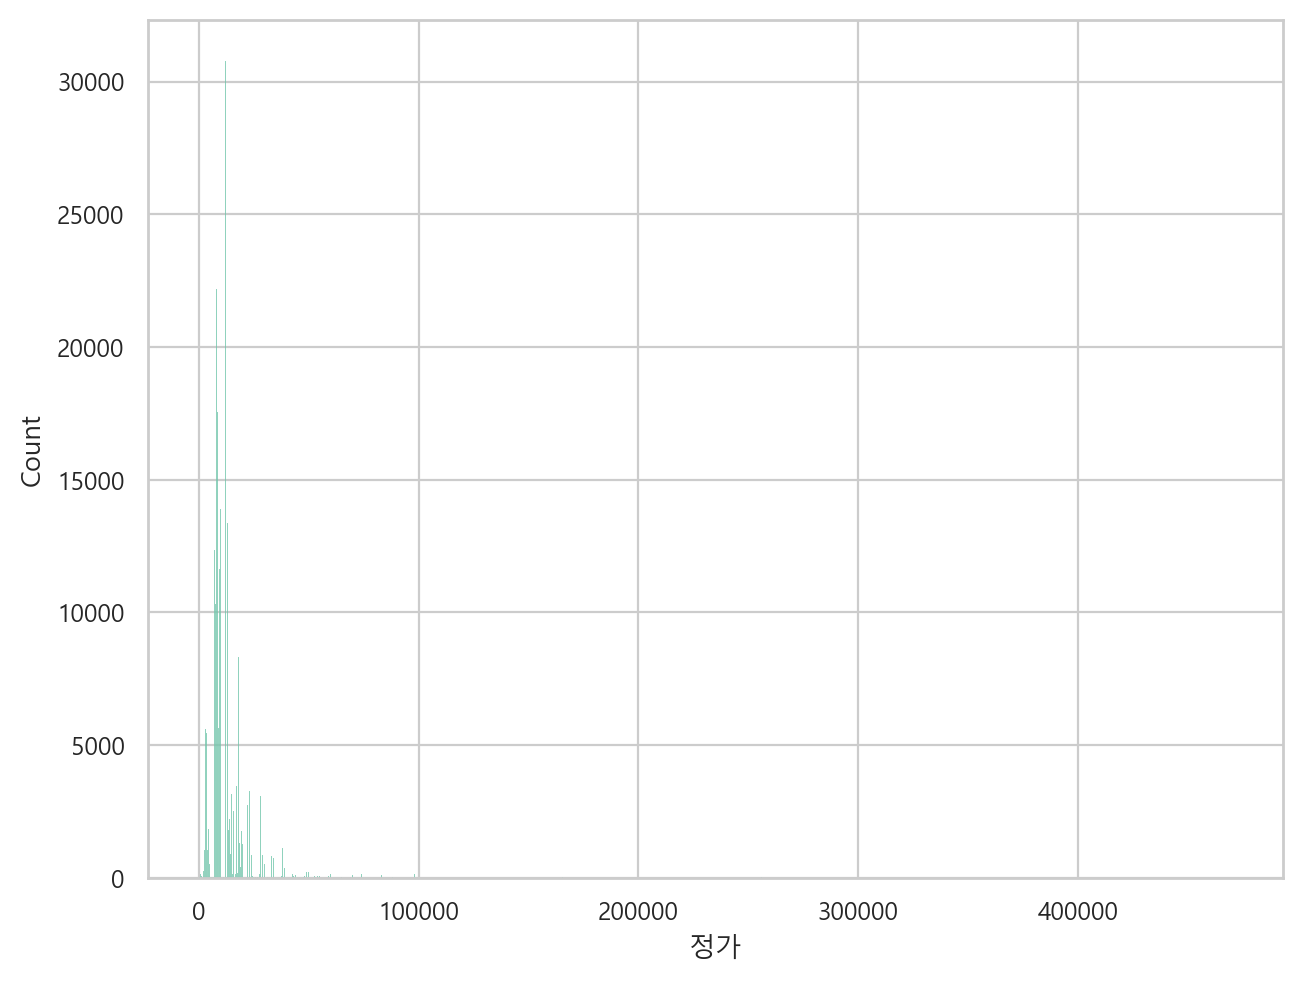

In [68]:
sns.histplot(df_filtered[col]);

판매가
<class 'str'>    345054
Name: count, dtype: int64

C:\Users\junsung\AppData\Local\Temp\ipykernel_6104\659068920.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = df_filtered[col].str.replace(',','')


0

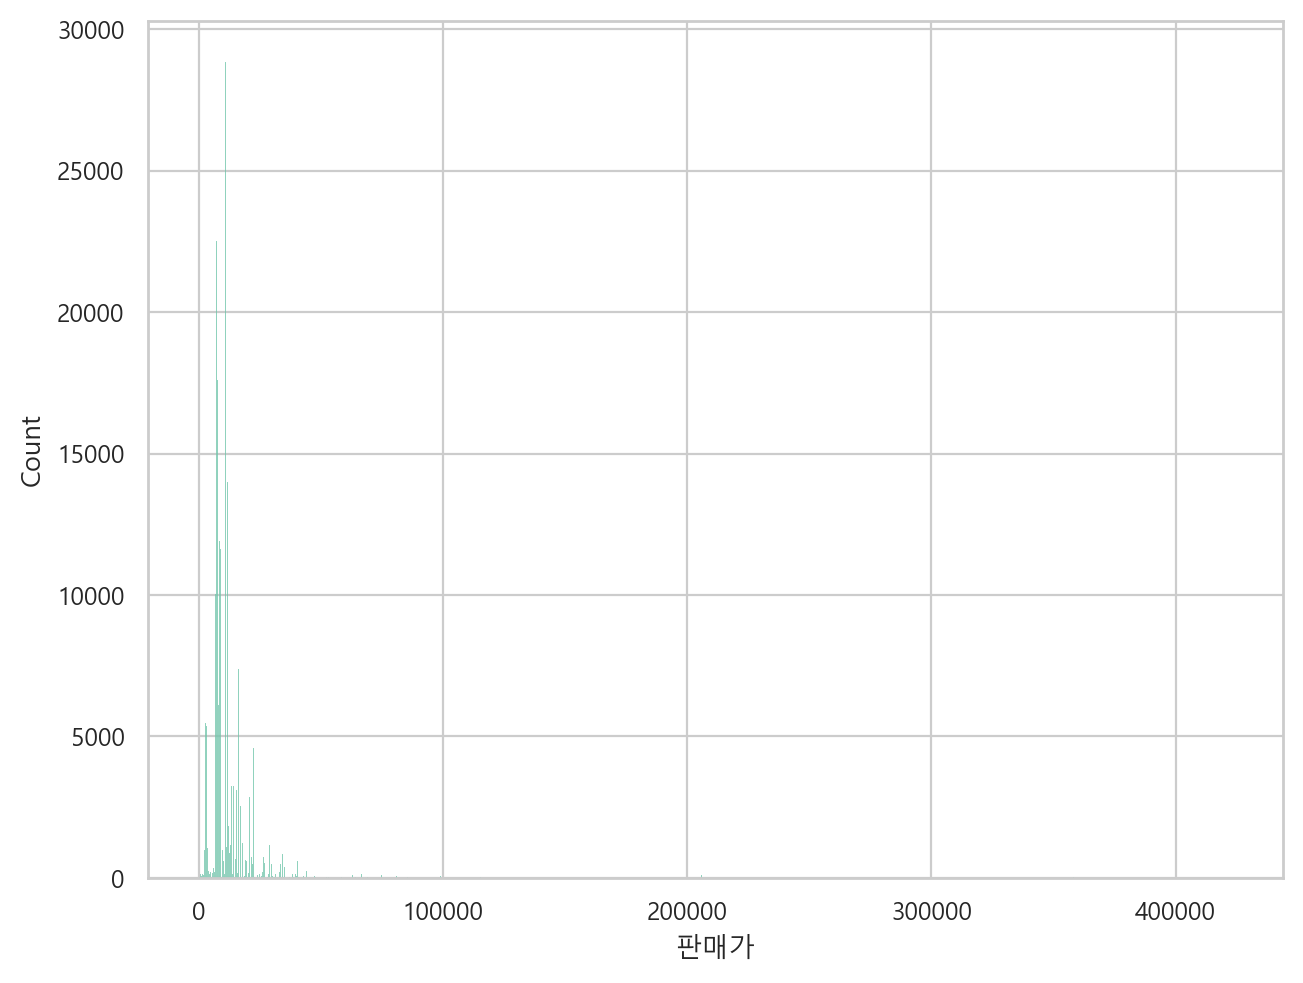

In [69]:
col = '판매가'
display(df_filtered[col].apply(type).value_counts())
df_filtered[col] = df_filtered[col].str.replace(',','')
temp = pd.to_numeric(df_filtered[col],errors='coerce')
display(np.sum(temp.isna()))
sns.histplot(temp);

In [70]:
df_filtered[col] = temp

C:\Users\junsung\AppData\Local\Temp\ipykernel_6104\3546829966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = temp


출간일
<class 'float'>    345054
Name: count, dtype: int64

0

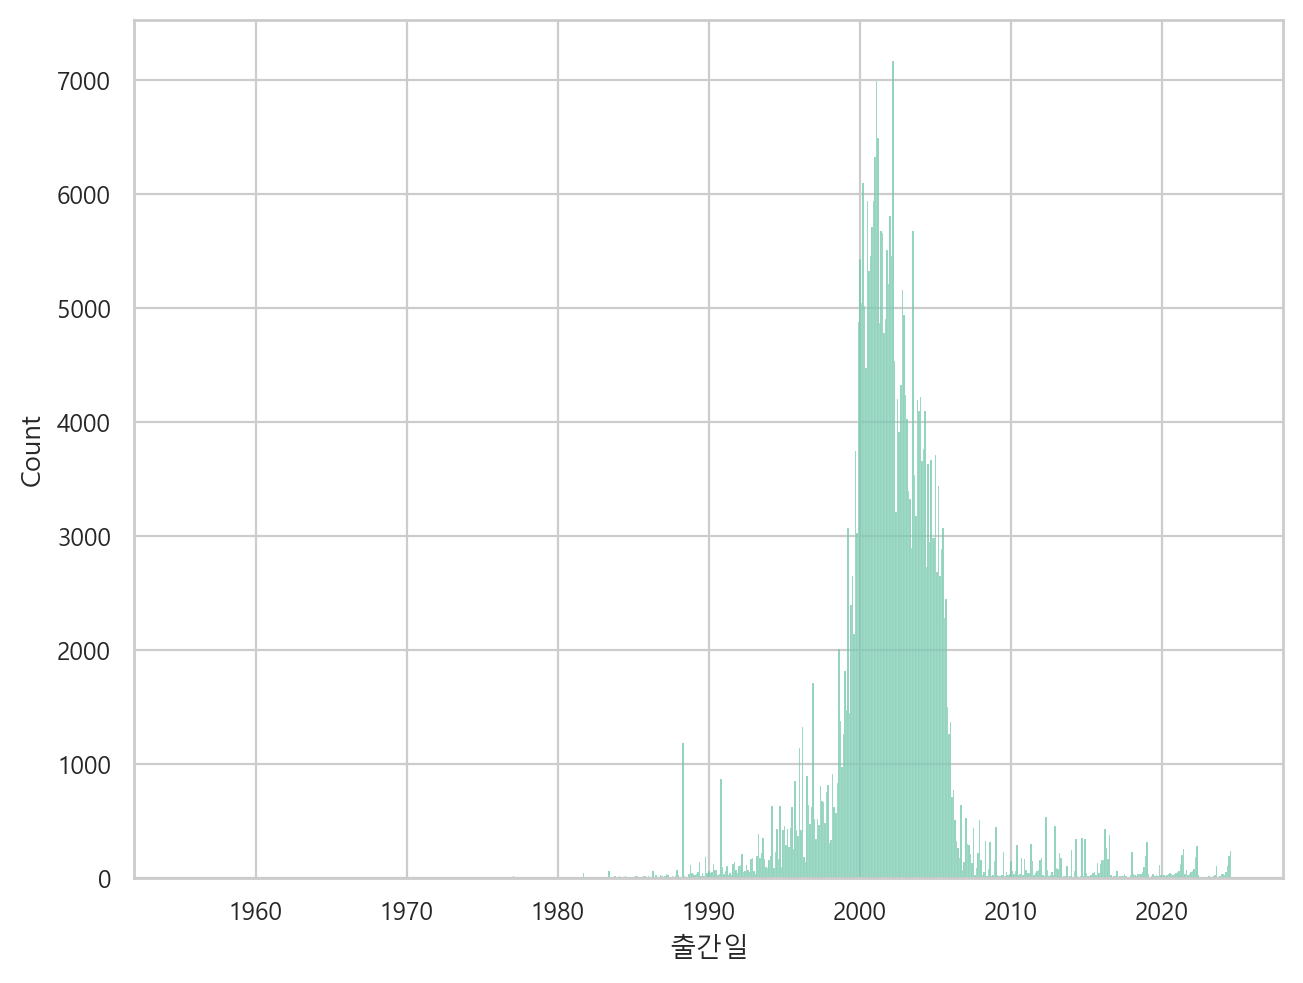

In [71]:
col = '출간일'
display(df_filtered[col].apply(type).value_counts())
temp = df_filtered[col].astype(int).astype(str)
temp = pd.to_datetime(temp,format='%Y%m%d')
sns.histplot(temp);
display(np.sum(temp.isna()))

In [72]:
df_filtered[col] = temp

C:\Users\junsung\AppData\Local\Temp\ipykernel_6104\3546829966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = temp


### 중복 확인

In [73]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 345054 entries, 0 to 999
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   순번/순위       345054 non-null  float64       
 1   구분          345054 non-null  object        
 2   상품명         345054 non-null  object        
 3   ItemId      345054 non-null  object        
 4   ISBN13      337009 non-null  object        
 5   부가기호        220272 non-null  object        
 6   저자/아티스트     345054 non-null  object        
 7   출판사/제작사     345054 non-null  object        
 8   출간일         345054 non-null  datetime64[ns]
 9   정가          345054 non-null  int64         
 10  판매가         345054 non-null  int64         
 11  마일리지        345054 non-null  object        
 12  세일즈포인트      345054 non-null  float64       
 13  대표분류(대분류명)  345054 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(9)
memory usage: 39.5+ MB


In [74]:
len(df_filtered['ItemId'].unique())

48011

In [75]:
df_filtered[df_filtered[['상품명','ItemId','저자/아티스트','출판사/제작사','출간일','정가','판매가','ISBN13']].duplicated(keep=False)]

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명)
0,1.0,국내도서,누가 내 치즈를 옮겼을까?,226139,-2147483648,3840.0,"스펜서 존슨 지음, 이영진 옮김",진명출판사,2000-03-15,7000,6300,350점,29660.0,자기계발
1,2.0,국내도서,부자 아빠 가난한 아빠 1,220359,-2147483648,3320.0,"로버트 기요사키, 샤론 레흐트 지음 | 형선호 옮김",민음인,2000-02-10,12000,10800,600점,22994.0,경제경영
3,4.0,국내도서,부자 아빠의 투자 가이드,247785,-2147483648,3320.0,"로버트 기요사키 지음, 박슬라 옮김",민음인,2014-09-26,18000,16200,900점,9245.0,경제경영
4,5.0,국내도서,부자 아빠 가난한 아빠 2,231099,-2147483648,3320.0,"로버트 기요사키 지음, 안진환 옮김",민음인,2012-11-27,17000,15300,850점,24851.0,경제경영
5,6.0,국내도서,창가의 토토,233350,-2147483648,3830.0,"구로야나기 테츠코 지음, 김난주 옮김, 이와사키 치히로 그림",프로메테우스,2004-01-29,11000,9900,550점,43114.0,소설/시/희곡
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,985.0,국내도서,"스토너 (초판본, 양장)",243703168,-2147483648,3840,"존 윌리엄스 지음, 김승욱 옮김",알에이치코리아(RHK),2020-06-24,18000,16200,900점,27648.0,소설/시/희곡
985,986.0,국내도서,백년운동,216483172,-2147483648,3470,정선근 지음,아티잔,2019-11-01,19500,17550,970점,37088.0,건강/취미
986,987.0,국내도서,생각에 관한 생각,140135544,-2147483648,3320,"대니얼 카너먼 지음, 이창신 옮김",김영사,2018-03-30,29800,26820,"1,490점",32148.0,경제경영
987,988.0,국내도서,던전밥 1,73442355,-2147483648,7830,"구이 료코 지음, 김완 옮김",㈜소미미디어,2015-12-29,7000,6300,350점,18373.0,만화


In [84]:
df_filtered[df_filtered['ItemId'].duplicated(keep=False)]

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명)
0,1.0,국내도서,누가 내 치즈를 옮겼을까?,226139,-2147483648,3840.0,"스펜서 존슨 지음, 이영진 옮김",진명출판사,2000-03-15,7000,6300,350점,29660.0,자기계발
1,2.0,국내도서,부자 아빠 가난한 아빠 1,220359,-2147483648,3320.0,"로버트 기요사키, 샤론 레흐트 지음 | 형선호 옮김",민음인,2000-02-10,12000,10800,600점,22994.0,경제경영
3,4.0,국내도서,부자 아빠의 투자 가이드,247785,-2147483648,3320.0,"로버트 기요사키 지음, 박슬라 옮김",민음인,2014-09-26,18000,16200,900점,9245.0,경제경영
4,5.0,국내도서,부자 아빠 가난한 아빠 2,231099,-2147483648,3320.0,"로버트 기요사키 지음, 안진환 옮김",민음인,2012-11-27,17000,15300,850점,24851.0,경제경영
5,6.0,국내도서,창가의 토토,233350,-2147483648,3830.0,"구로야나기 테츠코 지음, 김난주 옮김, 이와사키 치히로 그림",프로메테우스,2004-01-29,11000,9900,550점,43114.0,소설/시/희곡
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,985.0,국내도서,"스토너 (초판본, 양장)",243703168,-2147483648,3840,"존 윌리엄스 지음, 김승욱 옮김",알에이치코리아(RHK),2020-06-24,18000,16200,900점,27648.0,소설/시/희곡
985,986.0,국내도서,백년운동,216483172,-2147483648,3470,정선근 지음,아티잔,2019-11-01,19500,17550,970점,37088.0,건강/취미
986,987.0,국내도서,생각에 관한 생각,140135544,-2147483648,3320,"대니얼 카너먼 지음, 이창신 옮김",김영사,2018-03-30,29800,26820,"1,490점",32148.0,경제경영
987,988.0,국내도서,던전밥 1,73442355,-2147483648,7830,"구이 료코 지음, 김완 옮김",㈜소미미디어,2015-12-29,7000,6300,350점,18373.0,만화


In [85]:
cond1= df_filtered['ItemId'].duplicated(keep=False)
cond2= df_filtered[['ItemId','세일즈포인트']].duplicated(keep=False)
df_filtered[cond1&(~cond2)].sort_values(by=['ItemId','세일즈포인트'])

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명)
965,966.0,국내도서,그리운 여우,20706,-2147483648,3810.0,안도현 지음,창비,1997-07-15,10000,9500,500점,1045.0,소설/시/희곡
610,611.0,국내도서,낯선 곳에서 나를 만나다,29756,-2147483648,3330.0,한국문화인류학회 엮음,일조각,2006-08-25,13000,13000,0점,4700.0,인문학
574,575.0,국내도서,대지,37119,-2147483648,840.0,펄 S.벅 지음,(주)태일소담출판사,1994-01-01,5500,4950,270점,1156.0,소설/시/희곡
983,984.0,국내도서,대지,37119,-2147483648,840.0,펄 S.벅 지음,(주)태일소담출판사,1994-01-01,5500,4950,270점,1256.0,소설/시/희곡
812,813.0,국내도서,데미안,38151,-2147483648,850.0,헤르만 헤세 지음,(주)태일소담출판사,1991-11-01,5000,4500,250점,2563.0,소설/시/희곡
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,238.0,국내도서,1913년 세기의 여름,32264219,-2147483648,3920.0,"플로리안 일리스 지음, 한경희 옮김",문학동네,2013-10-19,23000,20700,230점,5191.0,인문학
939,940.0,국내도서,1913년 세기의 여름,32264219,-2147483648,3920,"플로리안 일리스 지음, 한경희 옮김",문학동네,2013-10-19,23000,20700,230점,5459.0,인문학
578,579.0,국내도서,동물농장,40674,-2147483648,4840,"조지 오웰 지음, 도정일 옮김",민음사,1998-08-05,8000,7200,400점,70766.0,소설/시/희곡
513,514.0,국내도서,던전밥 1,73442355,-2147483648,7830.0,"구이 료코 지음, 김완 옮김",㈜소미미디어,2015-12-29,7000,6300,350점,18133.0,만화


In [31]:
np.sum(df_filtered.loc[cond1&(~cond2),'ItemId'].value_counts() == 1)

14

- 예상보다는 중복이 많지 않음
- ItemId 중복 == '상품명','ItemId','저자/아티스트','출판사/제작사','출간일','정가','판매가' 중복
    - 위의 것들이 중복되지만 세일즈프인트가 중복되지 않는 케이스가 존재
    - 세일즈포인트, 판매가, 정가에 대해서 현재의 값과 대조 필요
        - 세일즈포인트의 경우, 업데이트 되는 시간대에 걸쳐서 파일들을 다운받았기 때문일 수 있음
- 저자 이름이 다 들어간 케이스와 '000 외'로 들어간 케이스를 어떻게 통일할지 차후에 정해야 함
- 저자 이름 전처리 필요
    - 지음, 엮음, 옮김, 감수 등으로 구별하는 것이 좋을 듯
    - 저자 : 지음 / 참여자 : (기타 담당) 으로 분리하는 것 필요
- pd.duplicated에서 한 번만 등장하는 itemid가 있는 이유 파악 필요

In [ ]:
book_df = pd.DataFrame(columns=['ID', 'Title', 'Rating', 'Author', 'Price', 'Pdate', 'Publisher', 'Btype', 'Salseindex'])



In [ ]:
# 가져올 책 범위,ID.. 값 정의
start_id = 97043285 # 125190808
end_id = 97046595





In [ ]:
# ID를 증가시키며 책 정보 크롤링
for book_id in range(start_id, end_id + 1):
    url = f'http://www.yes24.com/Product/Goods/{book_id}'
    try:
        r = requests.get (url)
        if r.status_code == 200:
            html=r.text
            soup=BeautifulSoup(html, 'lxml') #  BeautifulSoup 클래스의 인스턴스 생성

            # title = soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoTop > div > h2').get_text()
            try:
                title = soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoTop > div > h2').get_text()
            except AttributeError:
                title = None # 선택한 요소가 없어서 발생하는 AttributeError 처리

            try:
                rating = soup.select_one('#spanGdRating > a > em').get_text() # .get_text().strip()
            except AttributeError:
                rating = None

            try:
                author = soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoTop > span.gd_pubArea > span.gd_auth > a').get_text()
            except AttributeError:
                author = None

            btype = 'new'
            try:
                # if soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoTop > div > strong > em').get_text() == "중고도서":
                if "중고도서" in soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoTop > div > strong > em').get_text().lower():
                    price = soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoBot > div.gd_infoTbArea > div:nth-child(1) > table > tbody > tr.accentRow > td > span > em').get_text()  # 판매가격
                    btype = 'old'
                else:
                    price = soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoBot > div.gd_infoTbArea > div:nth-child(3) > table > tbody > tr:nth-child(2) > td > span > em').get_text()  # 판매가격
            except AttributeError:
                price = None

            try:
                pdate = soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoTop > span.gd_pubArea > span.gd_date').get_text()   # 발행일
            except AttributeError:
                pdate = None

            try:
                publisher = soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoTop > span.gd_pubArea > span.gd_pub > a').get_text()  # 출판사
            except AttributeError:
                publisher = None

            try:
                numbers = re.findall(r'\d+', soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoTop > span.gd_ratingArea > span.gd_sellNum').get_text().replace(',', ''))
                number = int(numbers[0]) if numbers else None
                salseindex = number # soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoTop > span.gd_ratingArea > span.gd_sellNum').get_text()  # 판매지수
            except AttributeError:
                salseindex = None



            # book_df = book_df.append({'ID':book_id, 'Title':title, 'Author':author, 'Rating':rating, 'Price':price, 'Pdate':pdate, 'Publisher':publisher, 'Btype':btype}, ignore_index=True)
            new_row = pd.DataFrame({'ID': [book_id], 'Title': [title], 'Author': [author], 'Rating': [rating], 'Price': [price], 'Pdate': [pdate], 'Publisher': [publisher], 'Btype': [btype], 'Salseindex': [salseindex]})
            book_df = pd.concat([book_df, new_row], ignore_index=True)

        else:
            print('에러발생1')
    except requests.RequestException as e:
        # 에러 발생시....
        print('에러발생2')
# book_df
book_df.to_csv('book.csv', encoding='euc-kr')
